### Context 
#### In this assignment, we will:
1. Determine the five most common journals and the total articles for each
2. Calculate the mean, median, and standard deviation of the open-access cost per article for each journal
3. BONUS: Identify the open access prices paid by subject area

In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from matplotlib import pyplot
import re
import seaborn as sns
%matplotlib inline


In [2]:
# Import data by iso-8859-1 encoding

data = pd.read_csv('WELLCOME_APCspend2013_forThinkful.csv', encoding='iso-8859-1')
data.columns = ['PMID/PMCID', 'Publisher', 'Journal title', 'Article title','Cost']
data_clean = data
data_clean.head()

,PMID/PMCID,Publisher,Journal title,Article title,Cost
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


In [3]:
data_clean.dtypes

PMID/PMCID       object
Publisher        object
Journal title    object
Article title    object
Cost             object
dtype: object

First, we will clean the journal titles by casting them in the title case and stripping additional white spaces. Then, we will see how many times each title occurs. To see if we have made progress with cleaning the Journal title column, we will view number of titles that only occur once as errors.

In [4]:
# Clean journal title column with using title case and strip whitespcae

data_clean['Journal title'] = data['Journal title'].apply(lambda x: str(x).title())
data_clean['Journal title'] = data['Journal title'].apply(lambda x: str(x).strip())

In [5]:
# Count occurance of titles

data_clean['count'] = data_clean.groupby('Journal title')['Journal title'].transform('count')
data_clean['count'] = data_clean['count'].sort_values()
len(data_clean[data_clean['count']==1])

569

Our previous method has not been very effective since there are 569 titles that occur only once. Next, we will attempt to establish title consistency by replacing abbreviations with the full form of the word.

In [6]:
# Clean inconsistent journal names by spelling out abbreviations

data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('J ','Journal of '))
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('The Journal ','Journal of '))
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('Med ','Medicinal '))
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('Chem','Chemistry '))
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('Org','Organic '))
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('Mol','Molecular '))                                                                                        
data_clean['Journal title'] = data_clean['Journal title'].apply(lambda x: str(x).replace('Pharm','Pharmaceutics ')) 
data_clean['Journal title'].head()                                                                                

0             Psychological Medicine
1                  Biomacromolecules
2    Journal of Medicinal Chemistry 
3    Journal of Medicinal Chemistry 
4     Journal of Organic  Chemistry 
Name: Journal title, dtype: object

Now that the journal title column is a bit more clean, we will start modifying the price column. The data in the price column is formatted as a string. We will need to convert the data to numeric values and removed the currency symbol into another column. 

In [7]:
# Create and clean the price column using a regular expression to assign numeric format

data_clean['Price'] = data_clean['Cost'].str.findall(r'\d+[.]\d+')
data_clean['Price'] = data_clean['Price'].apply(lambda x: x[0] if x else 0)
data_clean['Price'] = data_clean['Price'].apply(lambda x: pd.to_numeric(x))
data_clean['Price'].head()

0       0.00
1    2381.04
2     642.56
3     669.64
4     685.88
Name: Price, dtype: float64

In [8]:
# Assign currency to their own column using regex 

data_clean['Currency'] = data_clean['Cost'].str.findall(r'£')
data_clean['Currency'] = data_clean['Cost'].str.findall(r'$')
# NOTE: currency sign did not carry over 

In [9]:
# Columns with null values

data_clean.isnull().sum()

PMID/PMCID       199
Publisher          0
Journal title      0
Article title      0
Cost               0
count              0
Price              0
Currency           0
dtype: int64

Since there are not any missing values in the journal title or price column, we will check if there are potentially any incorrect values in the price column with a boxplot.

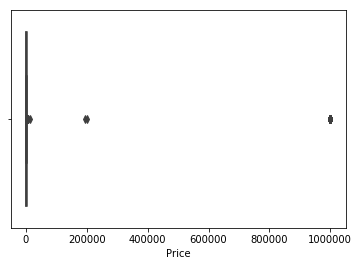

In [10]:
ax = sns.boxplot(x=data_clean['Price'])

There are mulitple high price points beyond the upper tail of the boxplot. Let's take a closer look at these outliers in the top 3%.

In [11]:
# Check for outliers

price_outliers = data_clean[data_clean['Price'] > data_clean['Price'].quantile(.97)]
print(price_outliers)

                                            PMID/PMCID  \
149                                         PMC3234811   
227                                            3708772   
277                                        PMC3668259    
358                                         PMC3219211   
404                                         PMC3533396   
410                                                NaN   
490                                         PMC3650559   
491                                  PMCID: PMC3464430   
526                                                NaN   
552                                23541370 PMC3744751   
560                                         PMC3632754   
630    Epub ahead of print April 2013 - print in press   
648                                                NaN   
660                           PMID:23291342 PMC3581773   
668                                  PMCID: PMC3594747   
669                                         PMC3594749   
670           

There are several articles that are priced at £999999.00 which may have been an indicator of missing values. We will replace £999999.00 with NaN and then substitue it with the mean price for that journal. 

In [12]:
# Compute the mean price of each article

data_clean[data_clean['Price'] == 999999.00] = None
mean = data_clean.groupby(['Journal title'])['Price'].mean()
data_clean['Price'] = data_clean['Price'].fillna(mean)

Now, let's check for outliers in the top 1% of the dataset.

In [13]:
# Check for outliers

price_outliers = data_clean[data_clean['Price'] > data_clean['Price'].quantile(.99)]
print(price_outliers)

                             PMID/PMCID                  Publisher  \
490                          PMC3650559                   Elsevier   
526                                 NaN                   Elsevier   
542                             3605578                   Elsevier   
552                 23541370 PMC3744751                   Elsevier   
648                                 NaN                   Elsevier   
668                   PMCID: PMC3594747                   Elsevier   
728                          PMC3748348                   Elsevier   
729                             2875410                   Elsevier   
786                   PMCID: PMC3694306                   Elsevier   
796                          PMC3525981                   Elsevier   
797                                 NaN                   Elsevier   
798            PMCID:\n    PMC3627205\n                   Elsevier   
799                                 NaN                   Elsevier   
800   PMID: 23041239

If we look at the last four rows, the prices are super high compared to other prices. The maxium value is priced at £201024.00. This may have been a decimal placement error since most of the prices in the top 1% are around £4000.00. So we will move the decimal to the proper place to eliminate outliers. 

In [14]:
# Moving decimal place of price outliers

data_clean['Price'].replace(201024.00, 2010.24, inplace=True)
data_clean['Price'].replace(192645.00, 1926.45, inplace=True)
data_clean['Price'].replace(13200.00, 1320.00, inplace=True)
data_clean['Price'].replace(6000.00, 600.00, inplace=True)

Now we are ready to answer the questions. 

#### 1. Determine the five most common journals and the total articles for each

In [15]:
data_clean['Journal title'].value_counts()[:5]

Plos One                                           183
Journal Of Biological Chemistry istry               52
Neuroimage                                          29
Nucleic Acids Research                              26
Proceedings Of The National Academy Of Sciences     22
Name: Journal title, dtype: int64

#### 2. Calculate the mean, median, and standard deviation of the open-access cost per article for each journal

In [16]:
data_clean['Price'].groupby(data_clean['Journal title']).describe()

,count,mean,std,min,25%,50%,75%,max
Journal title,,,,,,,,
Academy Of Nutrition And Dietetics,1.0,2379.540000,NaN,2379.54,2379.5400,2379.540,2379.5400,2379.54
Acs Chemistry ical Biology,5.0,1418.186000,507.309560,947.07,1267.7600,1294.590,1294.7800,2286.73
Acs Chemistry ical Neuroscience,1.0,1186.800000,NaN,1186.80,1186.8000,1186.800,1186.8000,1186.80
Acs Nano,2.0,668.140000,35.708892,642.89,655.5150,668.140,680.7650,693.39
"Acta Crystallographica Section D, Biological Crystallography",1.0,771.420000,NaN,771.42,771.4200,771.420,771.4200,771.42
Acta Crystallographica Section D: Biological Crystallography,1.0,773.740000,NaN,773.74,773.7400,773.740,773.7400,773.74
Acta Crystallographica Section F: Structural Biology And Crystallization Communications,2.0,796.635000,15.605847,785.60,791.1175,796.635,802.1525,807.67
"Acta Crystallographica, Section D",1.0,757.180000,NaN,757.18,757.1800,757.180,757.1800,757.18
Acta Crystallography D,1.0,774.190000,NaN,774.19,774.1900,774.190,774.1900,774.19
